In [1]:
import sys
sys.path.append('../../build')
import cv2 as cv
import numpy as np
import libry as ry
import time
import math
import random
# from perception import find_ball
#print(cv.__version__)

In [2]:
from environment import *
env = Environment(ry, math, np, time, random)

Update thrower position


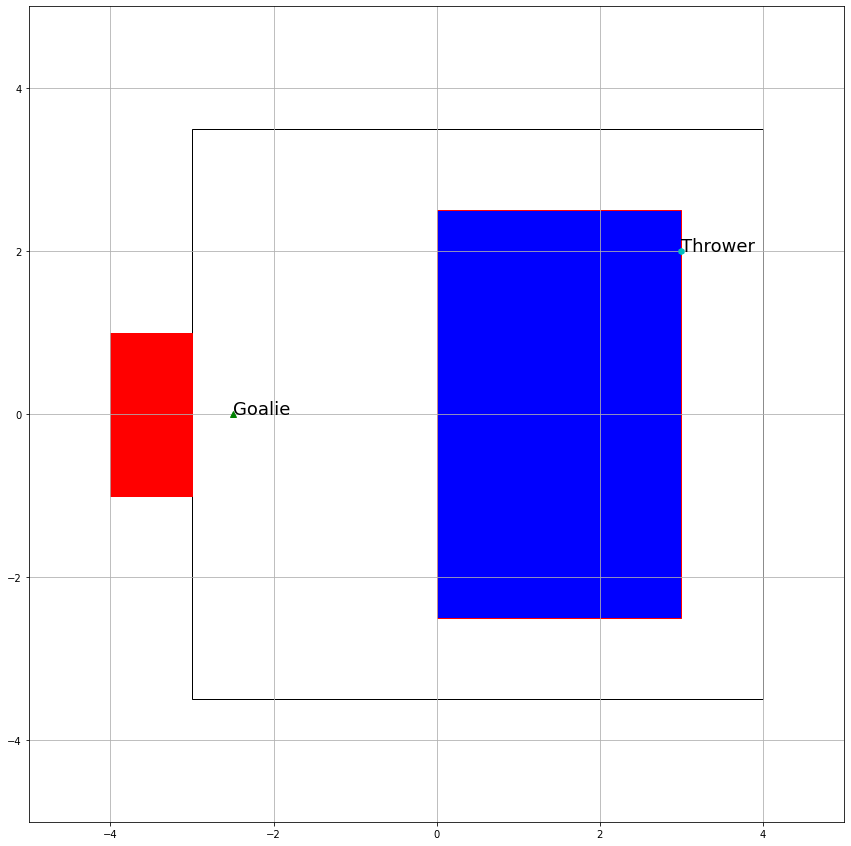

OK 3.0 2.0
Move thrower to initial position
Reset ball position
Move above the ball
Picking up the ball
Grasping the ball
Lift the ball
Throwing the ball
Overriding the move_to and grab objectives...
Stopping the ball
5.176470915349172
4.610356486096102
4.471036918378326
4.331255592538054
4.1920189868096545
4.0523591208654715
3.9127043772540873
3.7733736337840678
3.633842278697021
3.4942985138480998
3.354856796240344
3.215261594031898
3.075836759055906
2.936357516291335
2.797056433263392
2.6576160434945515
2.5188215090345545
2.3794539797412453
2.2292270332209205
2.07977707125318
1.9301274082897788
1.7803247865099154
1.630497794670384
1.4807155556048026
1.3310331660096695
1.1816094607126864
1.0249132624263964
0.8698616476703331
0.7143511618952856
0.5584418182401362
0.40226968907727423
0.24603185725574137
0.09033689816175164
0.10309652979370384
0.1198152488509713
0.1354224527949734
0.16086783675595187
0.18743994589443255
0.2140290649469516
0.24060086837107347
0.2671903335096461
0.2937707

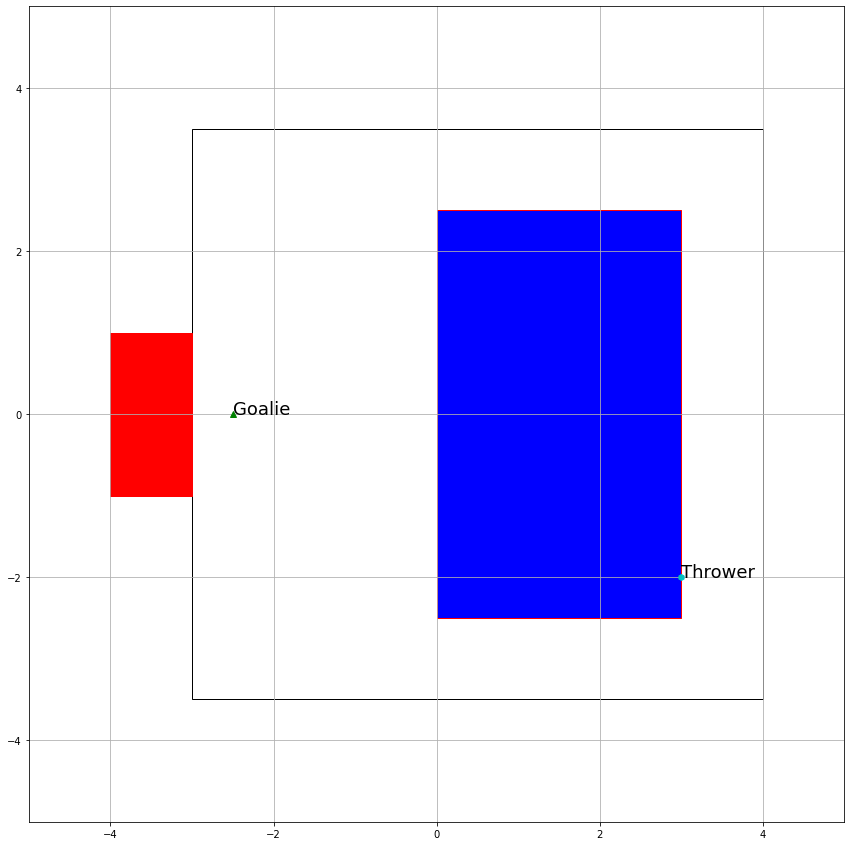

OK 3.0 -2.0
Move thrower to initial position
Reset ball position
Move above the ball
Picking up the ball
Grasping the ball
Lift the ball
Throwing the ball
Overriding the move_to and grab objectives...
Stopping the ball
4.774652153568178
4.562680894854137
4.441894486463222
4.320979397485456
4.200048690735701
4.079073488199104
3.9580335264474305
3.8372685493077316
3.7165503344575854
3.5954044591899152
3.4690451845989387
3.3443619663679174
3.2195969580813673
3.09492781348176
2.970364968774651
2.8459621334462573
2.7218307405986386
2.5979612659397495
2.4745178770972243
2.3515170375102117
2.2139946347876442
2.0797979424152833
1.94536559630987
1.8107251667809887
1.6760123825945759
1.541399389847193
1.4071196582079764
1.273467174960906
1.1408454155040157
1.009754107526182
0.8807081658433826
0.7542394234937408
0.6306550754202855
0.5098982344946281
0.3926153970006997
0.28599594132562
0.20552275590680213
0.127270267559864
0.062198889886606074
0.06891818332660045
0.07421847013339299
0.075859711063

In [ ]:
#Environment initialization
env.start()

# Start gui
#posx, posy = thrower_gui(env, 0)

# Throw and block
env.throw_and_block(options={
    "Thrower1": {
        "algorithm": 2,
        "get_thrower_position_using": "gui",
        "change_thrower_position_smoothly": True,
        "reset_with_random_position": True,
        "loop": True
    }
})